<a href="https://colab.research.google.com/github/joshuacalloway/dsc540groupproject/blob/main/StartingTrumpTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using NLP on Trump's Tweets
- Joshua Calloway
- DSC 540, Fall Quarter - DePaul


# Motivation [ 10 ]
What problem are you tackling, and what's the setting you're considering? What data are you working on? Did anything change from the proposal regarding data, objectives, and methods that you will apply?


We are looking Trump's tweets and applying NLP to see if we can determine the following
- Sentiment Analysis
- Subjectivity Analysis ( How objective or not are the tweets )
- @readDonaldTrump contains tweets by Trump and also his publicity staff.  See if we can determine which are by Trump
- Using GPT-2 to see if we can generate tweets that Trump might tweet

We are using tweets from thetrumparchive, which has about 50,0000 tweets and also another set with 1000 of Trump's latest tweets.  This is in alignment with the project proposal to use NLP on Trump

# Exploratory Data Analysis (EDA) [30]

What data visualizations have you applied? What are your findings in the data before applying any data mining technique? At this stage sufficient EDA should have been done.

We will load the tweets from the archive.  It does have various features such as text, device, retweets, favorities, isDeleted, isRetweet, date.  We can visualize the numerical columns via correlation graphs and apply one hot encoding on categorical data.

The text of the tweet will be vectorized and we will show word clouds and histograms.

# Machine Learning (ML) [10]: Which ML techniques have you tried? What others will you apply?

- libraries of tweepy and TextBlob to get Sentiment and Subjectivity
- NLTK NaiveBayesClassifier to build a classifier and train it with a training set.
- GPT-2 for tweet generation

# Experiment results [10]: Show the ML experiments that you've run, the outcomes, and any error analysis that you've done

- See boxplots, correlation of other features of the tweet data set.
- See data cleaning of tweets below
- See application of NLTK NaiveBayesClassifier for prediction
- See WordClouds

# Next steps [10]: Given your preliminary results, what are the next steps that you're considering?
- Improve accuracy by better tweet cleaning and or adding tweet specific language like emojis or shorthand
- Use GPT-2 for tweet generation
- Figure a way to measure accuracy and do cross validation to try to come up with better models
- Hyper-parameter tuning of the models
- Use models, methods on larger Trump tweets data of 50,0000 tweets

## A. Fetch 1000 of Trump's latest tweets, and try it out
Here we use thetrumparchive to fetch 1000 of Trump's latest tweets.  The tweets come back as JSON in format of
<code>
{
  id: 1
  text: 'Lets win Michigan'
  isRetweet: True
  isDeleted: False
  device: iPhone
  favorites: 323,
  retweets: 2
  date: 2020-11-02
}
</code>

In [1]:
import urllib.request, json
from sklearn.model_selection import train_test_split

In [39]:

def fetch_data(largeData=False):
    if largeData:
        data = []      # fetch 50,0000 tweets
    else:
        with urllib.request.urlopen("https://www.thetrumparchive.com/latest-tweets") as url:
            data = json.loads(url.read().decode())
    return data

get_tweet_text = lambda tweet : tweet['text']


In [40]:
# we r interested in the text for NLP
data = fetch_data()

print(get_tweet_text(data[0])) 


Get out &amp; VOTE! Under my Administration, our ECONOMY is growing at the fastest rate EVER at 33.1%. Next year will be the GREATEST ECONOMIC YEAR in American History!

Find your polling place below. https://t.co/OODmll3Snt


## B. Let's use a tweepy and TextBlob to see what common sentiment and subjectivity of each Tweet 

Two blogs that use tweepy and TextBlob can be found at 
- https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/analyze-tweet-sentiment-in-python/
- https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082



In [5]:
# We r going to use tweepy and TextBlob for tweets

import tweepy as tw
from textblob import TextBlob

In [6]:
# First we load the tweets into a pandas DataFrame
from pandas import DataFrame

df = DataFrame(data)
df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,1323692146147340299,RT @realDonaldTrump: VOTE! VOTE! VOTE!\nhttps:...,True,False,Twitter for iPhone,0,119268,2020-11-03T18:22:55.000Z
1,1323692020880297986,https://t.co/zX4bqgtWqH,False,False,Twitter for iPhone,54933,11790,2020-11-03T18:22:25.000Z
2,1323691984989622272,https://t.co/SMaOF79kPV,False,False,Twitter for iPhone,52485,12737,2020-11-03T18:22:16.000Z
3,1323684790894297089,RT @BarstoolNewsN: The Amish are not playing a...,True,False,Twitter for iPhone,0,19016,2020-11-03T17:53:41.000Z
4,1323680963310866435,"A parade for me in Nigeria, a great honor! htt...",False,False,Twitter for iPhone,221056,43186,2020-11-03T17:38:29.000Z


In [7]:
# So we could possibly use isRetweet as a label and try to predict the probability of a tweet being retweeted based on the text
df['isRetweet'].value_counts()

False    684
True     316
Name: isRetweet, dtype: int64

In [8]:
import pandas as pd
df["favorites"] = pd.to_numeric(df["favorites"])
df["retweets"] = pd.to_numeric(df["retweets"])

In [9]:
df.dtypes

id           object
text         object
isRetweet      bool
isDeleted      bool
device       object
favorites     int64
retweets      int64
date         object
dtype: object

<AxesSubplot:>

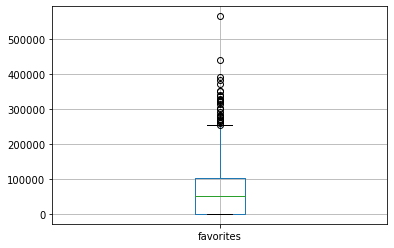

In [10]:
df.boxplot(column=['favorites'])

<AxesSubplot:>

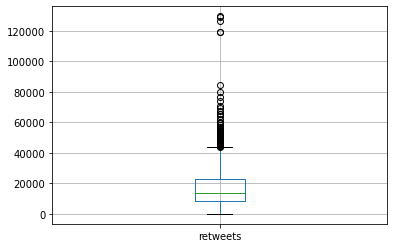

In [11]:
df.boxplot(column=['retweets'])


In [12]:
df['device'].value_counts()

Twitter for iPhone    999
Twitter Web App         1
Name: device, dtype: int64

In [13]:
# Favorites is correlated to retweets
df['favorites'].corr(df['retweets'])

0.713369331473916

In [14]:
# Define some cleaning methods for the Tweet Text
# Create a function to clean the tweets
import re

def clean_tweet(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", text).split())
    return text.lower()


In [15]:

# Very simple, if score is negative, we mark the Polarity as negative
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [16]:
# we clean the text for each Tweet
df['text'] = df['text'].apply(clean_tweet)

# Show the cleaned tweets
df

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,1323692146147340299,vote vote vote,True,False,Twitter for iPhone,0,119268,2020-11-03T18:22:55.000Z
1,1323692020880297986,,False,False,Twitter for iPhone,54933,11790,2020-11-03T18:22:25.000Z
2,1323691984989622272,,False,False,Twitter for iPhone,52485,12737,2020-11-03T18:22:16.000Z
3,1323684790894297089,the amish are not playing around today,True,False,Twitter for iPhone,0,19016,2020-11-03T17:53:41.000Z
4,1323680963310866435,a parade for me in nigeria a great honor,False,False,Twitter for iPhone,221056,43186,2020-11-03T17:38:29.000Z
...,...,...,...,...,...,...,...,...
995,1316598194894233601,nancy pelosi couldnt care less about the ameri...,False,False,Twitter for iPhone,136384,34359,2020-10-15T04:34:05.000Z
996,1316596552757063680,people are fleeing california taxes too high c...,False,False,Twitter for iPhone,281230,55088,2020-10-15T04:27:34.000Z
997,1316596424478527488,,False,False,Twitter for iPhone,65882,12920,2020-10-15T04:27:03.000Z
998,1316595899985014784,,False,False,Twitter for iPhone,169571,31104,2020-10-15T04:24:58.000Z


# C. We compute Subjectivity and Polarity of Tweet using TextBlob
- subjectivity is how opinionated a tweet is ( scaled from 1 to -1 )
- polarity is whether or not the tweet is positive or negative ( scaled from 1 to -1 )

In [17]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

# We eliminate words less then 3 characters long and standardize all words to lowercase
def filter_words(words):
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]
    return words_filtered



# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['text'].apply(getSubjectivity)
df['Polarity'] = df['text'].apply(getPolarity)


# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,Subjectivity,Polarity
0,1323692146147340299,vote vote vote,True,False,Twitter for iPhone,0,119268,2020-11-03T18:22:55.000Z,0.000000,0.000000
1,1323692020880297986,,False,False,Twitter for iPhone,54933,11790,2020-11-03T18:22:25.000Z,0.000000,0.000000
2,1323691984989622272,,False,False,Twitter for iPhone,52485,12737,2020-11-03T18:22:16.000Z,0.000000,0.000000
3,1323684790894297089,the amish are not playing around today,True,False,Twitter for iPhone,0,19016,2020-11-03T17:53:41.000Z,0.000000,0.000000
4,1323680963310866435,a parade for me in nigeria a great honor,False,False,Twitter for iPhone,221056,43186,2020-11-03T17:38:29.000Z,0.491667,0.275000
...,...,...,...,...,...,...,...,...,...,...
995,1316598194894233601,nancy pelosi couldnt care less about the ameri...,False,False,Twitter for iPhone,136384,34359,2020-10-15T04:34:05.000Z,0.336458,0.176042
996,1316596552757063680,people are fleeing california taxes too high c...,False,False,Twitter for iPhone,281230,55088,2020-10-15T04:27:34.000Z,0.526667,0.273333
997,1316596424478527488,,False,False,Twitter for iPhone,65882,12920,2020-10-15T04:27:03.000Z,0.000000,0.000000
998,1316595899985014784,,False,False,Twitter for iPhone,169571,31104,2020-10-15T04:24:58.000Z,0.000000,0.000000


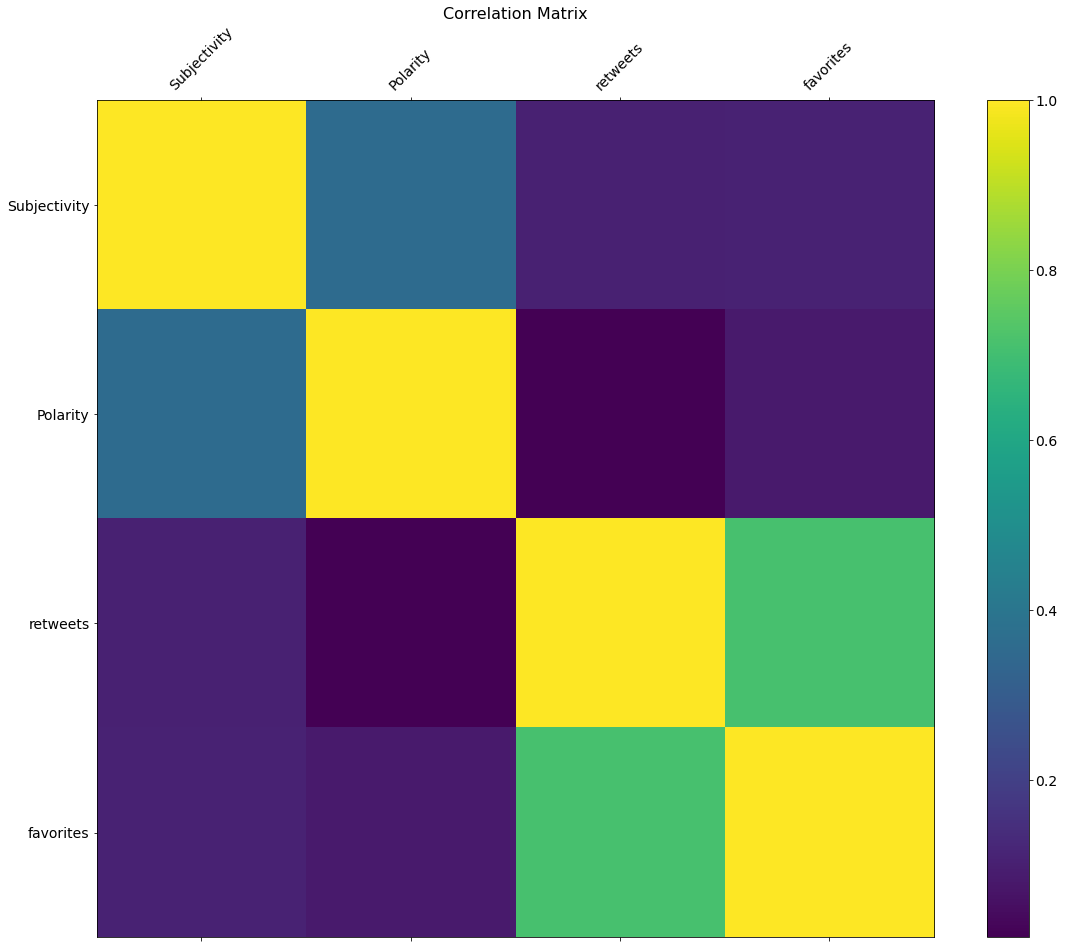

In [18]:
import matplotlib.pyplot as plt

newdf = df[['Subjectivity', 'Polarity', 'retweets', 'favorites']]

f = plt.figure(figsize=(19, 15))
plt.matshow(newdf.corr(), fignum=f.number)
plt.xticks(range(newdf.shape[1]), newdf.columns, fontsize=14, rotation=45)
plt.yticks(range(newdf.shape[1]), newdf.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Here we see a correlation between retweets and favorites

# D. For fun, we create a wordcloud of Trump's positive and negative tweets

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# word cloud visualization of all Tweets
allWords = ' '.join([twts for twts in df['text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)



### All Tweets word cloud

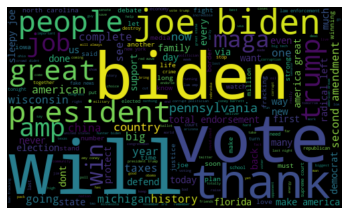

In [20]:
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### word cloud visualization for positive tweets


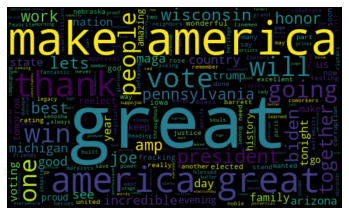

In [21]:
positive_words = df[df.Polarity > 0.5]['text']

allWords = ' '.join([twts for twts in positive_words])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### word cloud visualization for positive tweets


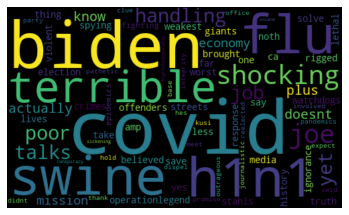

In [22]:
negative_words = df[df.Polarity < -0.5]['text']

allWords = ' '.join([twts for twts in negative_words])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### word cloud visualization for Subjective tweets


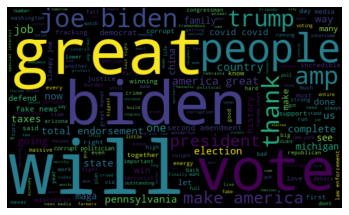

In [23]:
subjective_words = df[df.Subjectivity > 0.5]['text']

allWords = ' '.join([twts for twts in subjective_words])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [24]:
### word cloud visualization for Objective tweets


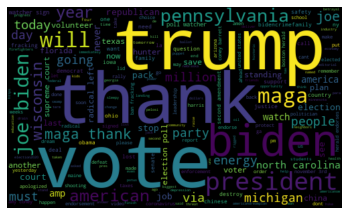

In [25]:
objective_words = df[df.Subjectivity < 0.1]['text']

allWords = ' '.join([twts for twts in objective_words])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# D. Trying NLTK to analyze NLP on Trump's Tweets as outlined in

- http://www.laurentluce.com/posts/twitter-sentiment-analysis-using-python-and-nltk/
- https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed

We need to create a training set of tweets labelled positive or negative

In [26]:
def tweet_text_from_tuple(tweet):
    return tweet[0]

def tweet_sentiment_from_tuple(tweet):
    return tweet[1]

def transform_tweet(tweet):
    if tweet['Polarity'] > 0:
        return (tweet['text'], 'positive')
    else:
        return (tweet['text'], 'negative')
        

In [27]:
pos_tweets = []
neg_tweets = []
for index, row in df.iterrows():
    tweet = transform_tweet(row)
    if (tweet[1] == 'negative'):
        neg_tweets.append(tweet)
    else:
        pos_tweets.append(tweet)

len(neg_tweets)

594

In [28]:


tweets = []
for (words, sentiment) in pos_tweets + neg_tweets:
    words_filtered = filter_words(words)
    tweets.append((words_filtered, sentiment))

In [29]:
tweets

[(['parade', 'for', 'nigeria', 'great', 'honor'], 'positive'),
 (['lets',
   'make',
   'america',
   'great',
   'again',
   'and',
   'reelect',
   'our',
   'fantastic',
   'president'],
  'positive'),
 (['thank', 'you', 'paris', 'keep', 'the', 'great', 'work'], 'positive'),
 (['new',
   'analysis',
   'with',
   'dont',
   'believe',
   'the',
   'polls',
   'trump',
   'winning',
   'trumpislosing',
   'trump'],
  'positive'),
 (['heading',
   'grand',
   'rapids',
   'michigan',
   'after',
   'great',
   'evening',
   'kenosha',
   'wisconsin',
   'get',
   'out',
   'and',
   'vote',
   'tomorrow',
   'lets',
   'make',
   'america',
   'great',
   'again'],
  'positive'),
 (['vote',
   'for',
   'sleepy',
   'joe',
   'biden',
   'vote',
   'give',
   'control',
   'government',
   'over',
   'globalists',
   'communists',
   'socialists',
   'and',
   'wealthy',
   'liberal',
   'hypocrites',
   'who',
   'want',
   'silence',
   'censor',
   'cancel',
   'and',
   'punish',


In [30]:
import nltk

def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

In [31]:
word_features = get_word_features(get_words_in_tweets(tweets))
word_features

dict_keys(['parade', 'for', 'nigeria', 'great', 'honor', 'lets', 'make', 'america', 'again', 'and', 'reelect', 'our', 'fantastic', 'president', 'thank', 'you', 'paris', 'keep', 'the', 'work', 'new', 'analysis', 'with', 'dont', 'believe', 'polls', 'trump', 'winning', 'trumpislosing', 'heading', 'grand', 'rapids', 'michigan', 'after', 'evening', 'kenosha', 'wisconsin', 'get', 'out', 'vote', 'tomorrow', 'sleepy', 'joe', 'biden', 'give', 'control', 'government', 'over', 'globalists', 'communists', 'socialists', 'wealthy', 'liberal', 'hypocrites', 'who', 'want', 'silence', 'censor', 'cancel', 'punish', 'maga', 'has', 'vowed', 'abolish', 'american', 'oil', 'natural', 'gas', 'industries', 'ban', 'fracking', 'long', 'will', 'remain', 'number', 'one', 'producer', 'earth', 'energy', 'independent', 'asking', 'your', 'favorite', 'still', 'have', 'win', 'this', 'amazing', 'linemen', 'power', 'save', 'friends', 'family', 'neighbors', 'coworkers', 'together', 'next', 'years', 'teach', 'children', 'lo

In [32]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [33]:
training_set = nltk.classify.apply_features(extract_features, tweets)

In [34]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [35]:
from nltk import ELEProbDist
def train(labeled_featuresets, estimator=ELEProbDist):
    # Create the P(label) distribution
    label_probdist = estimator(label_freqdist)
    # Create the P(fval|label, fname) distribution
    feature_probdist = {}
    return NaiveBayesClassifier(label_probdist, feature_probdist)

In [36]:
tweet = 'pennsylvania: is great!'
extract_features(tweet.split())

{'contains(parade)': False,
 'contains(for)': False,
 'contains(nigeria)': False,
 'contains(great)': False,
 'contains(honor)': False,
 'contains(lets)': False,
 'contains(make)': False,
 'contains(america)': False,
 'contains(again)': False,
 'contains(and)': False,
 'contains(reelect)': False,
 'contains(our)': False,
 'contains(fantastic)': False,
 'contains(president)': False,
 'contains(thank)': False,
 'contains(you)': False,
 'contains(paris)': False,
 'contains(keep)': False,
 'contains(the)': False,
 'contains(work)': False,
 'contains(new)': False,
 'contains(analysis)': False,
 'contains(with)': False,
 'contains(dont)': False,
 'contains(believe)': False,
 'contains(polls)': False,
 'contains(trump)': False,
 'contains(winning)': False,
 'contains(trumpislosing)': False,
 'contains(heading)': False,
 'contains(grand)': False,
 'contains(rapids)': False,
 'contains(michigan)': False,
 'contains(after)': False,
 'contains(evening)': False,
 'contains(kenosha)': False,
 'cont

### Trying out the classifier on various tweets

In [37]:
pos_tweets[5]

('a vote for sleepy joe biden is a vote to give control of government over to globalists communists socialists and wealthy liberal hypocrites who want to silence censor cancel and punish you get out and vote maga tomorrow',
 'positive')

In [38]:
classifier.classify(extract_features(filter_words(pos_tweets[5][0])))

'positive'

In [45]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

credential = AzureKeyCredential("cb61d607e5c8402b9742b8aa40207593")
text_analytics_client = TextAnalyticsClient(endpoint="https://trumptweetanalysissentiment.cognitiveservices.azure.com/", credential=credential)

In [46]:
documents = ["I hated the movie. It was so slow!", "The movie made it into my top ten favorites.", "What a great movie!"]

In [47]:
response = text_analytics_client.analyze_sentiment(documents)
successful_responses = [doc for doc in response if not doc.is_error]

In [49]:
len(successful_responses)

3

In [53]:
first = successful_responses[0]    # AnalyzeSentimentResult(**kwargs)  https://docs.microsoft.com/en-us/python/api/azure-ai-textanalytics/azure.ai.textanalytics.analyzesentimentresult?view=azure-python
print(first)

{'id': '0', 'sentiment': 'negative', 'warnings': [], 'statistics': None, 'confidence_scores': SentimentConfidenceScores(positive=0.0, neutral=0.0, negative=1.0), 'sentences': [SentenceSentiment(text=I hated the movie., sentiment=negative, confidence_scores=SentimentConfidenceScores(positive=0.0, neutral=0.0, negative=1.0)), SentenceSentiment(text=It was so slow!, sentiment=negative, confidence_scores=SentimentConfidenceScores(positive=0.0, neutral=0.0, negative=1.0))], 'is_error': False}
